<a href="https://colab.research.google.com/github/matiqiu/mcd-scanveg-ai-model-experiments/blob/main/Exp01_MobileNet_Frozen_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importaciones y configuración inicial y Autenticación de Kaggle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import os
import shutil
from google.colab import files

In [ ]:
# Subir el token de Kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deabejarano","key":"1f209696f09e5520275bf0f9e1de1289"}'}

In [ ]:
# Configurar Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 2. Descarga del Dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 96% 634M/658M [00:05<00:00, 125MB/s]
100% 658M/658M [00:05<00:00, 132MB/s]


In [ ]:
# 3. Preparación del Dataset
import os
import shutil

In [ ]:
# Rutas y parámetros
src_dir = '/content/PlantVillage'
dst_dir = '/content/tomate_10clases'
tomato_classes = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

In [ ]:
# Crear carpeta de destino (si no existe)
os.makedirs(dst_dir, exist_ok=True)

In [ ]:
# Copiar cada clase
for cls in tomato_classes:
    src_cls_path = os.path.join(src_dir, cls)
    dst_cls_path = os.path.join(dst_dir, cls)
    if os.path.isdir(src_cls_path):
        if os.path.exists(dst_cls_path):
            shutil.rmtree(dst_cls_path)
        shutil.copytree(src_cls_path, dst_cls_path)
    else:
        print(f"⚠️  Clase no encontrada: {cls}")

In [ ]:
# Verificar que quedaron 10 carpetas
print("Carpetas copiadas:")
print(sorted(os.listdir(dst_dir)))

Carpetas copiadas:
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# 4. Generadores de Datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Parámetros globales
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 20  # Puedes ajustar según el experimento

In [ ]:
# 5. Generadores de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dst_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dst_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.


In [ ]:
# 6. Construcción del Modelo
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 7. Callbacks y Entrenamiento
EXPERIMENT_NAME = "exp01_mobilenet_frozen"
model_path = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}.keras'
history_path = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_history.pkl'

# Verificar si ya existe un modelo guardado
if os.path.exists(model_path) and os.path.exists(history_path):
    # Cargar el modelo y el historial de entrenamiento
    model = tf.keras.models.load_model(model_path)
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    initial_epoch = len(history['loss'])
else:
    # Iniciar desde el principio
    initial_epoch = 0
    history = None

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks
)

# 8. Guardar el Modelo y el Historial
EXPERIMENT_NAME = "exp01_mobilenet_frozen"

model.save(f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}.keras')
with open(f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 947s 2s/step - accuracy: 0.2155 - loss: 2.2942 - val_accuracy: 0.6320 - val_loss: 1.3116
Epoch 2/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 932s 2s/step - accuracy: 0.5623 - loss: 1.3603 - val_accuracy: 0.7083 - val_loss: 0.9829
Epoch 3/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 937s 2s/step - accuracy: 0.6556 - loss: 1.0641 - val_accuracy: 0.7527 - val_loss: 0.8325
Epoch 4/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 938s 2s/step - accuracy: 0.6976 - loss: 0.9263 - val_accuracy: 0.7658 - val_loss: 0.7555
Epoch 5/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.7233 - loss: 0.8373 - val_accuracy: 0.7952 - val_loss: 0.6782
Epoch 6/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 941s 2s/step - accuracy: 0.7520 - loss: 0.7686 - val_accuracy: 0.8133 - val_loss: 0.6294
Epoch 7/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 926s 2s/step - accuracy: 0.7667 - loss: 0.7261 - val_accuracy: 0.8136 - val_loss: 0.6104
Epoch 8/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - accuracy: 0.7727 - loss: 0.6976 - val_accu

In [ ]:
# 9. Evaluación y Visualización
val_gen.reset()
y_pred_prob = model.predict(val_gen, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_gen.classes

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1-score: {f1}")

Accuracy: 0.8511569731081926
Precision: 0.8501349266409954
Recall: 0.8511569731081926
F1-score: 0.8503174380602349


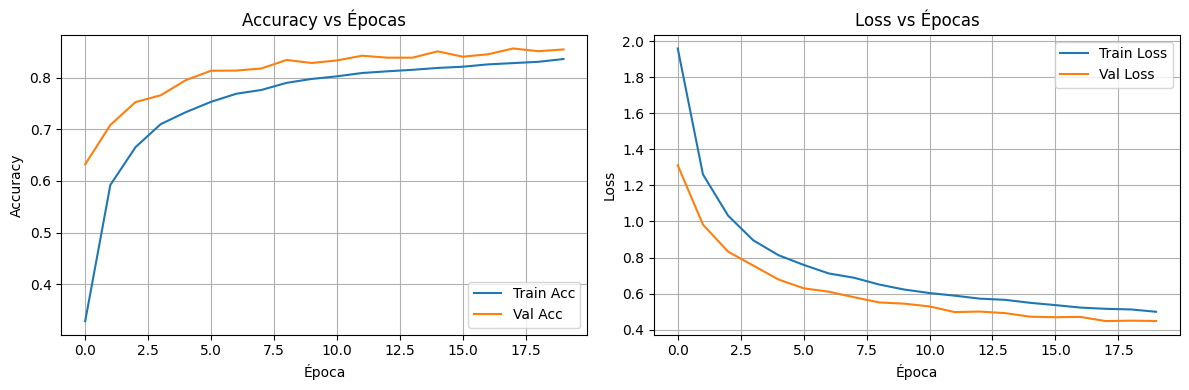

In [ ]:
# 10. Gráficos de métricas
import pandas as pd  # Importar pandas
hist_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Train Acc')
plt.plot(hist_df['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Épocas'); plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Val Loss')
plt.title('Loss vs Épocas'); plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(f'/content/{EXPERIMENT_NAME}_curvas.png', dpi=300)
plt.show()

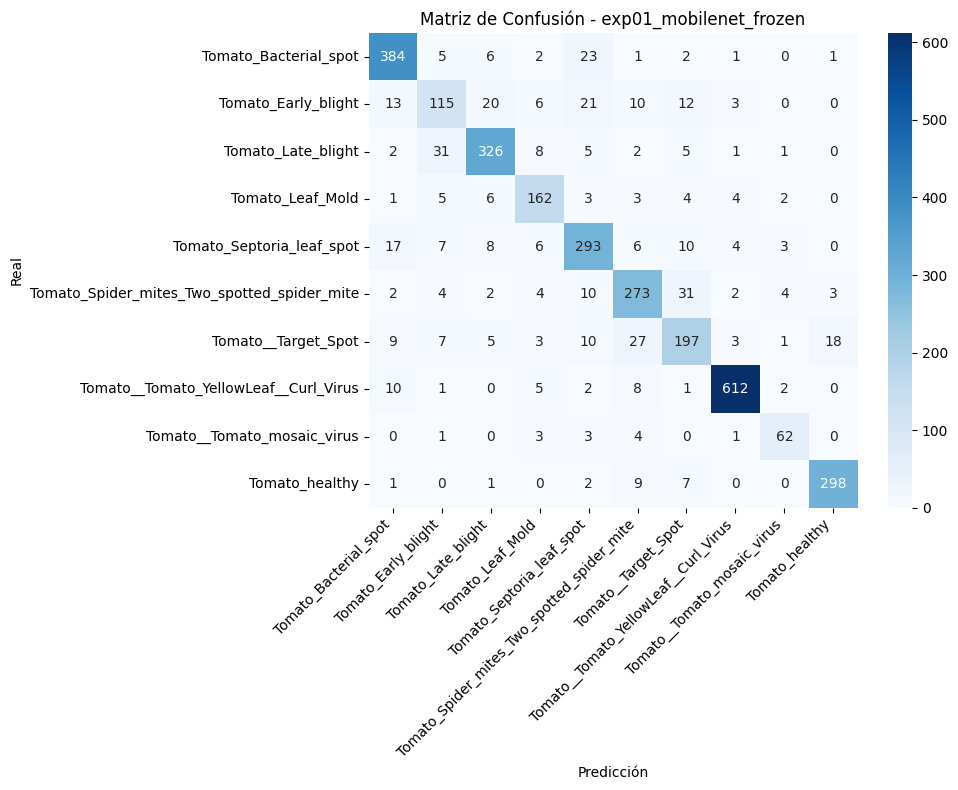

In [ ]:
# 11. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.title(f'Matriz de Confusión - {EXPERIMENT_NAME}')
plt.xlabel('Predicción'); plt.ylabel('Real')
plt.xticks(rotation=45, ha='right'); plt.tight_layout()
plt.savefig(f'/content/{EXPERIMENT_NAME}_matrix.png', dpi=300)
plt.show()